# CNN

In [1]:
import time
import copy
import random
import torch
from tqdm.notebook import trange, tqdm
from util import topk_acc
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = torch.device("cuda")

In [3]:
torch.manual_seed(0)
random.seed(0)

In [4]:
torch.backends.cudnn.benchmark = True

In [5]:
# 568s
data_pt = torch.load('./data/cnn2_c.pt')

In [7]:
num = len(data_pt)

train_set, dev_set, test_set = torch.utils.data.random_split(data_pt, [int(num * 0.98), int(num * 0.01), int(num * 0.01)])

datasets = {'train':train_set, 'dev':dev_set, 'test':test_set}
dataset_sizes = {x:len(datasets[x]) for x in ['train', 'dev','test']} 
dataloaders = {x:torch.utils.data.DataLoader(datasets[x], batch_size=1024,
                                         shuffle=True, pin_memory=True) for x in ['train', 'dev', 'test']} 

# Classification

In [38]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # self.up = nn.Upsample(scale_factor=2, mode='nearest')
        self.cnn = nn.Sequential(
            self.cnn_block(2, 64), #8*8
            self.cnn_block(64, 128), #4*4
            self.cnn_block(128, 256), #2*2
            )
        self.fc = nn.Sequential(
            self.fc_block(256, 7, final_layer=True),
            # self.fc_block(128, 7, ),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    def cnn_block(self, input_channels, output_channels):
        return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, (3,3), padding = 1),
                nn.BatchNorm2d(output_channels),
                nn.MaxPool2d((2,2)),
                nn.ReLU(True),
                )
    def fc_block(self, input_dim, output_dim, dropout=0.5, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Linear(input_dim, output_dim),
                nn.Dropout(dropout),
                nn.ReLU(True),
            )
        else:
            return nn.Sequential(
                nn.Linear(input_dim, output_dim),
                nn.Dropout(dropout),
            )
    def forward(self, x):
        # x = self.up(x) 
        x = self.cnn(x)
        # x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

net = Net().to(device)

In [39]:
sta = {x:{'epoch_acc':[], 'epoch_loss':[]} for x in ['train','dev']}

In [40]:
best_acc = 1/7

In [42]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 1e-3)
# optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.98)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 5, eta_min=1e-5, last_epoch=-1)

In [43]:
num_epochs = 20

In [44]:
for epoch in trange(num_epochs):
    for phase in ['train', 'dev']:
        if phase == 'train':
            net.train()  
        else:
            net.eval()   
        running_loss = 0.0
        running_corrects = 0
        for batch in dataloaders[phase]:
            
            inputs, labels = batch[0].to(device), batch[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            with torch.set_grad_enabled(phase == 'train'):
                outputs = net(inputs)
                top_acc = topk_acc(outputs, labels, 2)
                loss = criterion(outputs, labels)
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += top_acc

        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]


        # statistics recording
        sta[phase]['epoch_acc'].append(epoch_acc)
        sta[phase]['epoch_loss'].append(epoch_loss)

        # show the current dev acc and time
        if phase == 'dev':
            print('{:.3%}'.format(epoch_acc), time.strftime("%H:%M:%S", time.localtime()))
        # record parameters of the best net
        if phase == 'dev' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_net_wts = copy.deepcopy(net.state_dict())

  0%|          | 0/20 [00:00<?, ?it/s]

77.107% 17:13:22
78.328% 17:16:12
78.948% 17:19:08
79.598% 17:22:10
80.043% 17:25:22
80.188% 17:28:17


## Result

In [16]:
from util import plot_cm, plot_sta

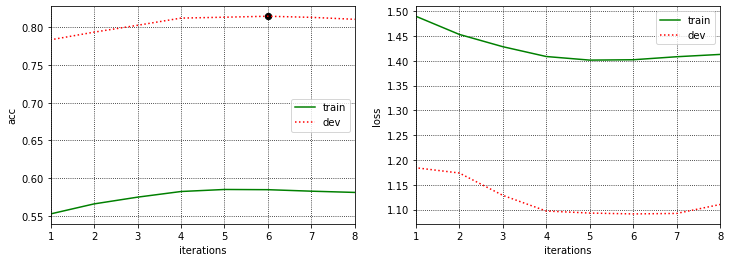

max train acc: 0.5849630952380952
max dev acc: 0.814725 at epoch 6
corresponding train acc: 0.5846846938775511


In [36]:
plot_sta(sta)

In [ ]:
plot_cm(net, dataloaders['train'])

In [ ]:
torch.save(net.state_dict(), './model/cnn1.pt')